# SCEE and Simphony

SiPANN includes a module that wraps all of the models produced by SCEE for easy use in [simphony](https://simphonyphotonics.readthedocs.io/en/latest/), allowing for cascading devices to make complex structures. This gives the user multiple options (Interconnect or Simphony) to cascade devices.

The SCEE wrapper can be found in `SiPANN.scee_int`.

In [1]:
from SiPANN import scee
from SiPANN.scee_int import SimphonyWrapper

from simphony.library import ebeam
from simphony.netlist import Subcircuit
from simphony.simulation import SweepSimulation, MonteCarloSweepSimulation

import matplotlib.pyplot as plt
import numpy as np

def pltAttr(x, y, title=None, legend='upper right', save=None):
    if legend is not None:
        plt.legend(loc=legend)
    plt.xlabel(x)
    plt.ylabel(y)
    if title is not None:
        plt.title(title)
    if save is not None:
        plt.savefig(save)

## Standard Simulation

First we'll make our device like we always have using `SiPANN.scee`.

In [2]:
r = 10000
w = 500
t = 220
wavelength = np.linspace(1500, 1600)
gap = 100

hr = scee.HalfRing(w, t, r, gap)

Simply put our device into the simphony wrapper.

In [3]:
s_hr = SimphonyWrapper(hr)

Then use in simphony like you would any other device. Here we'll make a ring resonator as an example.

In [4]:
def make_ring(half_ring):
    term = ebeam.ebeam_terminator_te1550()

    circuit = Subcircuit()
    circuit.add([
        (half_ring, 'input'),
        (half_ring, 'output'),
        (term, 'terminator')
    ])

    circuit.elements['input'].pins = ('pass', 'midb', 'in', 'midt')
    circuit.elements['output'].pins = ('out', 'midt', 'term', 'midb')

    circuit.connect_many([
        ('input', 'midb', 'output', 'midb'),
        ('input', 'midt', 'output', 'midt'),
        ('terminator', 'n1', 'output', 'term')
    ])
    
    return circuit

No handles with labels found to put in legend.


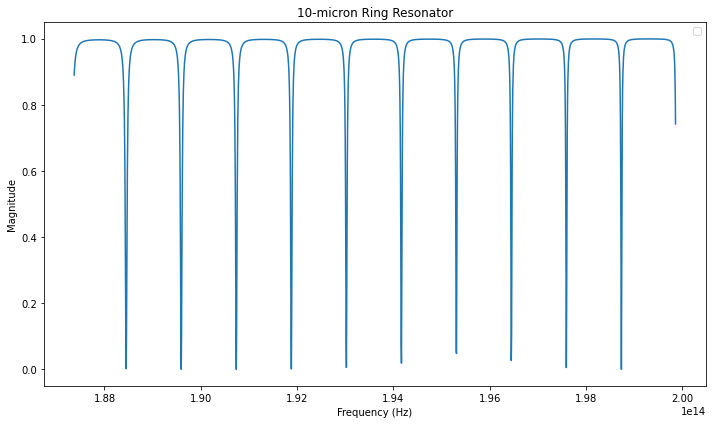

In [5]:
# Simphony takes in wavelength values in meters
circuit = make_ring(s_hr)
sim1 = SweepSimulation(circuit, 1500e-9, 1600e-9)
res1 = sim1.simulate()

f1, s = res1.data(res1.pinlist['in'], res1.pinlist['pass'])
plt.figure(figsize=(10,6))
plt.plot(f1, s)
pltAttr('Frequency (Hz)', 'Magnitude', "10-micron Ring Resonator")
plt.tight_layout()
plt.show()

## Monte-Carlo Simulations

`SimphonyWrapper` also functions with monte_carlo simulations. It allows ANY of the parameters set in SiPANN to be used. To use it you must include a dictionary mapping the parameter you wish to perturb to a standard deviation in nm. 

In [6]:
sigmas = {"width": 2, "thickness": 1}
s_hr = SimphonyWrapper(hr, sigmas)

And then simply make our circuit as before, and run through monte-carlo simulations

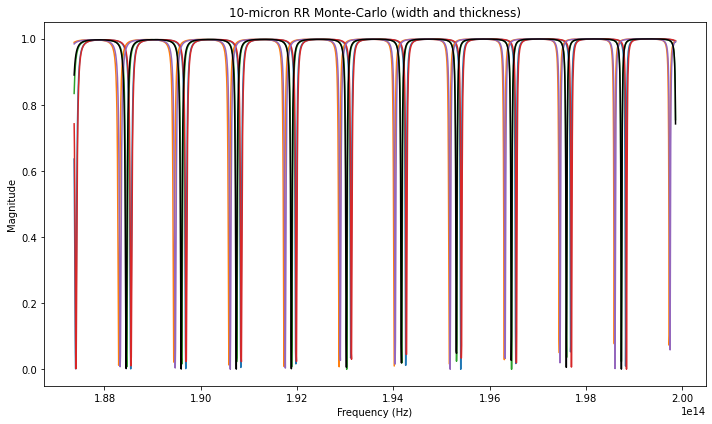

In [7]:
circuit = make_ring(s_hr)
#run monte carlo simulation
simulation = MonteCarloSweepSimulation(circuit, 1500e-9, 1600e-9)
runs = 5
result = simulation.simulate(runs=runs)

#plot
plt.figure(figsize=(10,6))
for i in range(1, runs + 1):
    f, s = result.data('in', 'pass', i)
    plt.plot(f, s)

# The data located at the 0 position is the ideal values.
f, s = result.data('in', 'pass', 0)
plt.plot(f, s, 'k')
pltAttr('Frequency (Hz)', 'Magnitude', "10-micron RR Monte-Carlo (width and thickness)", legend=None)
plt.tight_layout()
plt.show()

As an example, we'll do another simulation, but this time varying radius of the ring only. Note we could vary both sides of the ring independently as well (ie the gap distance on each side isn't necessarily going to be equal), but for simplicity using our `make_ring` function we have identical halves.

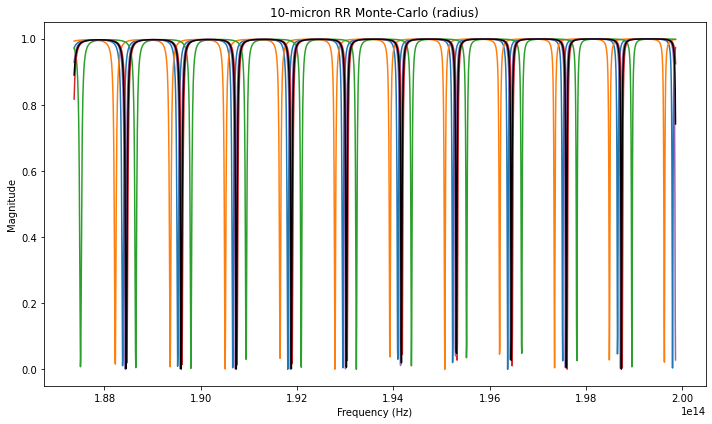

In [8]:
sigmas = {"radius": 20}
s_hr = SimphonyWrapper(hr, sigmas)

circuit = make_ring(s_hr)
#run monte carlo simulation
simulation = MonteCarloSweepSimulation(circuit, 1500e-9, 1600e-9)
runs = 5
result = simulation.simulate(runs=runs)

#plot
plt.figure(figsize=(10,6))
for i in range(1, runs + 1):
    f, s = result.data('in', 'pass', i)
    plt.plot(f, s)

# The data located at the 0 position is the ideal values.
f, s = result.data('in', 'pass', 0)
plt.plot(f, s, 'k')
pltAttr('Frequency (Hz)', 'Magnitude', "10-micron RR Monte-Carlo (radius)", legend=None)
plt.tight_layout()
plt.show()